# AML — Task 1
## Predict the age of a brain from MRI features
---

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from pandas_profiling import ProfileReport

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

## Import datasets

In [24]:
X_train = pd.read_csv('data/X_train.csv').drop(columns=['id'])
y_train = pd.read_csv('data/y_train.csv').drop(columns=['id'])

In [25]:
X_test = pd.read_csv('data/X_test.csv').drop(columns=['id'])

## Explore datasets

In [5]:
X_train.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
count,1118.000000,1114.000000,1117.000000,1106.000000,1.117000e+03,1128.000000,1105.000000,1127.000000,1.116000e+03,1124.000000,...,1.134000e+03,1125.000000,1098.000000,1121.000000,1120.000000,1109.000000,1115.000000,1.112000e+03,1124.000000,1091.000000
mean,10.026057,832442.859290,20585.524887,1048.958235,1.000291e+06,10.085010,597900.429955,10389.657239,9.998422e+05,785176.225858,...,1.049674e+06,-876.044006,13492.600186,10.554762,10.057767,1066.141107,10.008269,1.050199e+06,99798.480171,104903.905758
std,0.968347,0.028258,0.029051,28.430733,9.740891e+04,0.968026,0.028128,1655.843472,1.022441e+05,0.028799,...,2.839579e+04,164.585576,2519.835006,0.283844,0.982656,226.606986,1.018930,2.814210e+04,9576.128720,2768.405350
min,6.672068,832442.808579,20585.473808,1000.063783,6.800215e+05,6.984052,597900.381003,3644.074892,6.095730e+05,785176.176297,...,1.000105e+06,-1597.766964,2536.030655,10.010366,6.841039,496.007706,6.466963,1.000002e+06,73207.994891,100012.896777
25%,9.381273,832442.835941,20585.501013,1024.969967,9.360882e+05,9.470582,597900.406110,9339.537887,9.322937e+05,785176.201279,...,1.025054e+06,-975.398714,11947.954006,10.321039,9.379001,899.067501,9.325229,1.027575e+06,93416.252400,102596.190683
50%,10.000079,832442.860041,20585.524817,1047.985497,1.000557e+06,10.089601,597900.429787,10295.013382,1.001261e+06,785176.225608,...,1.049296e+06,-875.508235,13352.186179,10.554260,10.114370,1049.027077,10.005684,1.050262e+06,99802.127899,104846.235709
75%,10.664998,832442.882951,20585.550525,1073.180317,1.064617e+06,10.752707,597900.452983,11304.073469,1.068359e+06,785176.250421,...,1.074354e+06,-773.174562,14893.726023,10.792195,10.745370,1215.057985,10.658120,1.073831e+06,106400.748441,107098.669350
max,12.956099,832442.908334,20585.573514,1099.977638,1.331630e+06,12.747734,597900.480810,17347.531573,1.284804e+06,785176.276168,...,1.099771e+06,-281.030205,24815.260375,11.091050,13.530204,2122.032859,13.163113,1.099918e+06,130694.436443,109984.169649


In [6]:
# Quick look at outliers whiskers are at 1.5 IQR
X_train.boxplot(column=['x543'])

<AxesSubplot:>

---
## Outlier detection

### Method 1: IQR
- Drop every sample rows with any feature that is an outlier.
- This method is not conclusive as it drops way too many samples.

In [7]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

In [8]:
no_outliers = X_train[~((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1)]

In [9]:
print(f'We dropped {X_train.shape[0] - no_outliers.shape[0]} samples and have now {no_outliers.shape[0]} of them.') 

We dropped 1176 samples and have now 36 of them.


### Method 2: Z-score
- For every features we compute the absolute `z-score` of each sample of that feature.
- We then replace all scores above a tunable threshold by NaN values (filters the outliers).

In [10]:
X_train_abs_z_scores = np.abs(zscore(X_train, nan_policy='omit'))
X_train = X_train[(X_train_abs_z_scores < 3)]

---
## Pipeline Models

### Pipeline 1: Lasso Regression

1. **Imputation of missing values** using sklearn `KNN Impute`
2. **Data normalization** using sklear `Standard Scale`
3. **Feature selection** using sklearn `Lasso Regression`

In [11]:
pipe1 = Pipeline([
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler()), 
    ('lasso', Lasso(alpha=0.1, max_iter=100000))
])

In [12]:
pipe1.fit(X_train, y_train)

Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.1, max_iter=100000))])

In [22]:
pipe1.score(X_train, y_train)

NameError: name 'pipe1' is not defined

<AxesSubplot:ylabel='Frequency'>

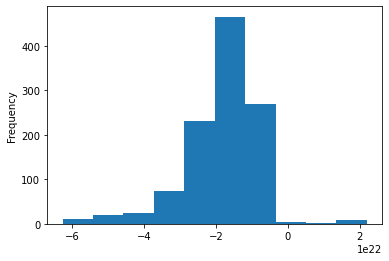

In [35]:
X_train['x400'].plot.hist()

In [32]:
y_train.describe()

,y
count,1212.000000
mean,69.665842
std,9.831347
min,42.000000
25%,64.000000
50%,70.000000
75%,76.000000
max,97.000000


## Predict

In [14]:
prediction = pd.DataFrame(pipe1.predict(X_test))

## Output solution

In [15]:
sub_id = 2
basepath = 'submissions/task1-sub'

In [16]:
result = prediction.copy()
result = result.rename(columns={0: 'y'})
result['id'] = range(0, len(result))
result = result[['id', 'y']]

In [17]:
result.to_csv(basepath+str(sub_id) + '.csv', index=False)